# 讀取圖像數據並準備數據

In [1]:
dataset_path = './dataset'

# 載入所需套件

In [2]:
%matplotlib inline
import os
import random
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from PIL import Image
import torchvision.models as models
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.utils import shuffle, resample
import numpy as np
import matplotlib.pyplot as plt
from miniflow import *
from tqdm.auto import tqdm

## 利用特徵提取器提取特徵

# 評估指標

In [3]:
def top_1_acc(y_true, y_pred):
    """
    計算 top 1 accuracy
    
    參數:
    y_true -- 真實標籤 (numpy array= m x 1)
    y_pred -- 模型預測機率 (numpy array= m x n)
    k -- 前 k 高的機率會被考慮 (int)
    m -- 樣本個數
    n -- 標籤數量
    
    回傳:
    accuracy -- top k accuracy (float)
    """
    sorted_indices = np.flip(np.argsort(y_pred,axis=1),axis=1) # Descent sorting
    pred_top1 = sorted_indices[:,0]
    accuracy = np.mean(y_true==pred_top1)
    
    return accuracy

def top_5_acc(y_true, y_pred):
    """
    計算 top 1 accuracy
    
    參數:
    y_true -- 真實標籤 (numpy array= m x 1)
    y_pred -- 模型預測機率 (numpy array= m x n)
    k -- 前 k 高的機率會被考慮 (int)
    m -- 樣本個數
    n -- 標籤數量
    
    回傳:
    accuracy -- top k accuracy (float)
    """
    k=2
    sorted_indices = np.flip(np.argsort(y_pred,axis=1),axis=1) # Descent sorting
    pred_top5 = sorted_indices[:,:5]
    num_correct = 0
    for i in range(y_true.shape[0]):
        if y_true[i] in pred_top5[i,:]:
            num_correct += 1
    accuracy = num_correct / len(y_true)
    
    return accuracy


# 訓練和評估模型

In [4]:
feature_name_list = ['Resnet50','HoG']

## Features taking

In [5]:
feature_name = feature_name_list[0]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(feature_name)
print(device)


Resnet50
cuda:0


In [6]:
train_features = np.load(os.path.join(dataset_path,'train_features_'+feature_name+'.npy'))
train_labels = np.load(os.path.join(dataset_path,'train_labels_'+feature_name+'.npy'))
val_features = np.load(os.path.join(dataset_path,'val_features_'+feature_name+'.npy'))
val_labels = np.load(os.path.join(dataset_path,'val_labels_'+feature_name+'.npy'))
test_features = np.load(os.path.join(dataset_path,'test_features_'+feature_name+'.npy'))
test_labels = np.load(os.path.join(dataset_path,'test_labels_'+feature_name+'.npy'))

## One Layer Perception

![image.png](./oneLP.png/)

In [7]:
X_ = train_features
y_ = train_labels

n_features = X_.shape[1]
n_hidden = 1
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)

In [8]:
# Neural network
X, y = Input(), Input()
W1, b1 = Input(), Input()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
cost = MSE(y, s1)

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
}

In [9]:
epochs = 100

# Total number of examples
train_num = train_features.shape[0]
val_num = val_features.shape[0]
train_batch_size = train_num
val_batch_size = val_num
train_steps_per_epoch = train_num // train_batch_size
val_steps_per_epoch = val_num // val_batch_size

graph = topological_sort(feed_dict)
trainables = [W1, b1]

print("Total number of examples = {}".format(train_num))

Total number of examples = 63325


In [10]:
graph

In [11]:
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
# Step 4
for i in range(epochs):
    train_loss = 0
    val_loss = 0
    # ----- training ------
    for j in range(train_steps_per_epoch): 
        # Step 1
        # Randomly sample a batch of examples
        X_batch, y_batch = resample(train_features, train_labels, n_samples=train_batch_size)
        
        # Reset value of X and y Inputs
        X.value = X_batch
        y.value = y_batch
        
        # Step 2
        forward_and_backward(graph)

        # Step 3
        sgd_update(trainables)

        train_loss += graph[-1].value
        
        # Step 5 
        train_top_1 = top_1_acc(y.value, s1.value)

    train_loss_list.append(train_loss/train_steps_per_epoch)
    train_acc_list.append(train_top_1/train_steps_per_epoch)

    # ----- validation ------   
    for k in range(val_steps_per_epoch): 
        # Step 1
        # Randomly sample a batch of examples
        X_batch, y_batch = resample(val_features, val_labels, n_samples=val_batch_size)

        # Reset value of X and y Inputs
        X.value = X_batch
        y.value = y_batch

        # Step 2
        forward_and_backward(graph)

        # Step 3: validation with no update
        # sgd_update(trainables)

        val_loss += graph[-1].value
        
        # Step 5 
        val_top_1 = top_1_acc(y.value, s1.value)     
    
    val_loss_list.append(val_loss/val_steps_per_epoch)
    val_acc_list.append(val_top_1/val_steps_per_epoch)
    
    if (i+1)%10 == 0:
        print("Epoch: {}: Train Loss: {:.3f}, Train accuracy: {:.3f}; Val Loss: {:.3f}, Val accuracy: {:.3f}".format(
            i+1, train_loss/train_steps_per_epoch, train_top_1/train_steps_per_epoch,
            val_loss/val_steps_per_epoch, val_top_1/val_steps_per_epoch))
print('--- Done. ---')

Epoch: 10: Train Loss: 778.175, Train accuracy: 0.020; Val Loss: 723.812, Val accuracy: 0.009
Epoch: 20: Train Loss: 771.626, Train accuracy: 0.021; Val Loss: 711.681, Val accuracy: 0.031
Epoch: 30: Train Loss: 772.190, Train accuracy: 0.020; Val Loss: 753.401, Val accuracy: 0.016
Epoch: 40: Train Loss: 770.679, Train accuracy: 0.020; Val Loss: 753.808, Val accuracy: 0.020
Epoch: 50: Train Loss: 770.462, Train accuracy: 0.020; Val Loss: 715.115, Val accuracy: 0.038
Epoch: 60: Train Loss: 769.171, Train accuracy: 0.021; Val Loss: 761.755, Val accuracy: 0.009
Epoch: 70: Train Loss: 771.513, Train accuracy: 0.019; Val Loss: 784.218, Val accuracy: 0.013
Epoch: 80: Train Loss: 771.715, Train accuracy: 0.020; Val Loss: 770.485, Val accuracy: 0.022
Epoch: 90: Train Loss: 767.162, Train accuracy: 0.021; Val Loss: 757.970, Val accuracy: 0.009
Epoch: 100: Train Loss: 770.484, Train accuracy: 0.021; Val Loss: 789.678, Val accuracy: 0.011
--- Done. ---


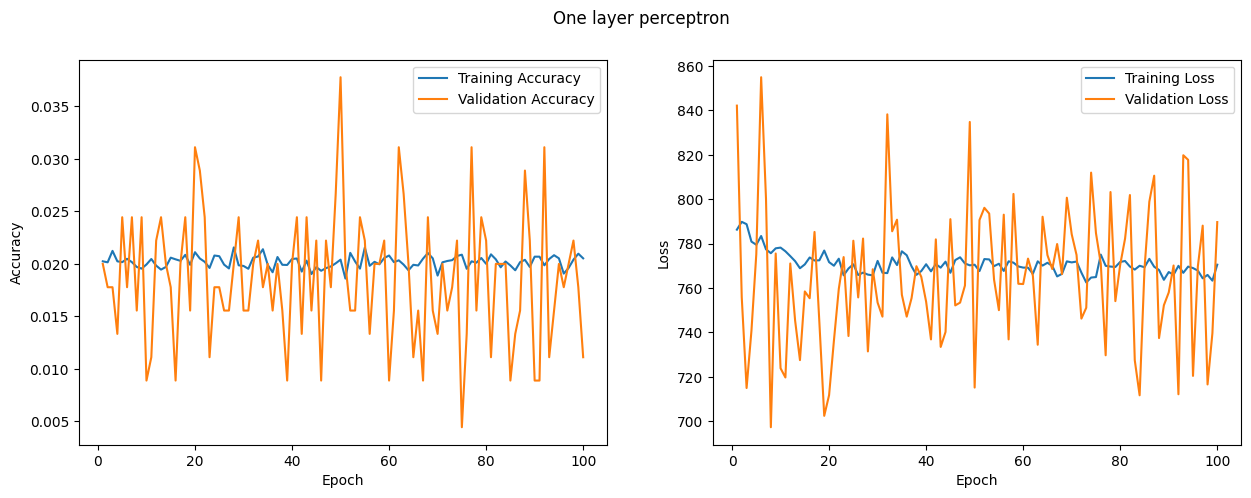

In [12]:
# Plot the accuracy and loss in the same figure
fig,ax = plt.subplots(1,2,figsize=(15, 5))
fig.suptitle('One layer perceptron')
ax[0].plot(range(1,epochs+1),train_acc_list, label='Training Accuracy')
ax[0].plot(range(1,epochs+1),val_acc_list, label='Validation Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[1].plot(range(1,epochs+1),train_loss_list, label='Training Loss')
ax[1].plot(range(1,epochs+1),val_loss_list, label='Validation Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
plt.show()



### 評估模型

In [13]:
X.value = train_features
y.value = train_labels
forward_and_backward(graph)
Train_acc = top_1_acc(y.value, s1.value)

X.value = val_features
y.value = val_labels
forward_and_backward(graph)
Val_acc = top_1_acc(y.value, s1.value)

X.value = test_features
y.value = test_labels
forward_and_backward(graph)
Test_acc = top_1_acc(y.value, s1.value)

print('One layer perceptron')
print('Train accuracy: {:.3f}; Val accuracy: {:.3f}; Test accuracy: {:.3f}'.format(
        Train_acc, Val_acc, Test_acc))

One layer perceptron
Train accuracy: 0.020; Val accuracy: 0.020; Test accuracy: 0.020


## Two Layer Perception

![image.png](./twoLP.png/)

In [14]:
X_ = train_features
y_ = train_labels

n_features = X_.shape[1]
n_hidden = 10
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

In [15]:
# Neural network
X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

In [16]:
epochs = 100
# Total number of examples
train_num = train_features.shape[0]
val_num = val_features.shape[0]
train_batch_size = train_num
val_batch_size = val_num
train_steps_per_epoch = train_num // train_batch_size
val_steps_per_epoch = val_num // val_batch_size

graph = topological_sort(feed_dict)
trainables = [W1, b1, W2, b2]

print("Total number of examples = {}".format(train_num))


Total number of examples = 63325


In [17]:
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
# Step 4
for i in range(epochs):
    train_loss = 0
    val_loss = 0
    for j in range(train_steps_per_epoch): # training set
        # Step 1
        # Randomly sample a batch of examples
        X_batch, y_batch = resample(train_features, train_labels, n_samples=train_batch_size)
        
        # Reset value of X and y Inputs
        X.value = X_batch
        y.value = y_batch
        
        # Step 2
        forward_and_backward(graph)

        # Step 3
        sgd_update(trainables)

        train_loss += graph[-1].value
        
        # Step 5 
        train_top_1 = top_1_acc(y.value, l2.value)

    train_loss_list.append(train_loss/train_steps_per_epoch)
    train_acc_list.append(train_top_1/train_steps_per_epoch)
        
    for k in range(val_steps_per_epoch): # validation set
        # Step 1
        # Randomly sample a batch of examples
        X_batch, y_batch = resample(val_features, val_labels, n_samples=val_batch_size)

        # Reset value of X and y Inputs
        X.value = X_batch
        y.value = y_batch

        # Step 2
        forward_and_backward(graph)

        # Step 3
        # sgd_update(trainables)

        val_loss += graph[-1].value
        
        # Step 5 
        val_top_1 = top_1_acc(y.value, l2.value)     
    
    val_loss_list.append(val_loss/val_steps_per_epoch)
    val_acc_list.append(val_top_1/val_steps_per_epoch)
    
    if (i+1)%10 == 0:
        print("Epoch: {}: Train Loss: {:.3f}, Train accuracy: {:.3f}; Val Loss: {:.3f}, Val accuracy: {:.3f}".format(
            i+1, train_loss/train_steps_per_epoch, train_top_1/train_steps_per_epoch,
            val_loss/val_steps_per_epoch, val_top_1/val_steps_per_epoch))
print('--- Done. ---')

Epoch: 10: Train Loss: 249.472, Train accuracy: 0.020; Val Loss: 231.119, Val accuracy: 0.009
Epoch: 20: Train Loss: 205.078, Train accuracy: 0.020; Val Loss: 199.513, Val accuracy: 0.022
Epoch: 30: Train Loss: 196.382, Train accuracy: 0.020; Val Loss: 194.117, Val accuracy: 0.020
Epoch: 40: Train Loss: 186.948, Train accuracy: 0.021; Val Loss: 178.257, Val accuracy: 0.029
Epoch: 50: Train Loss: 178.713, Train accuracy: 0.020; Val Loss: 168.573, Val accuracy: 0.013
Epoch: 60: Train Loss: 170.049, Train accuracy: 0.021; Val Loss: 183.079, Val accuracy: 0.022
Epoch: 70: Train Loss: 164.357, Train accuracy: 0.021; Val Loss: 161.741, Val accuracy: 0.020
Epoch: 80: Train Loss: 156.855, Train accuracy: 0.018; Val Loss: 166.132, Val accuracy: 0.013
Epoch: 90: Train Loss: 153.551, Train accuracy: 0.020; Val Loss: 156.119, Val accuracy: 0.011
Epoch: 100: Train Loss: 148.639, Train accuracy: 0.020; Val Loss: 154.553, Val accuracy: 0.020
--- Done. ---


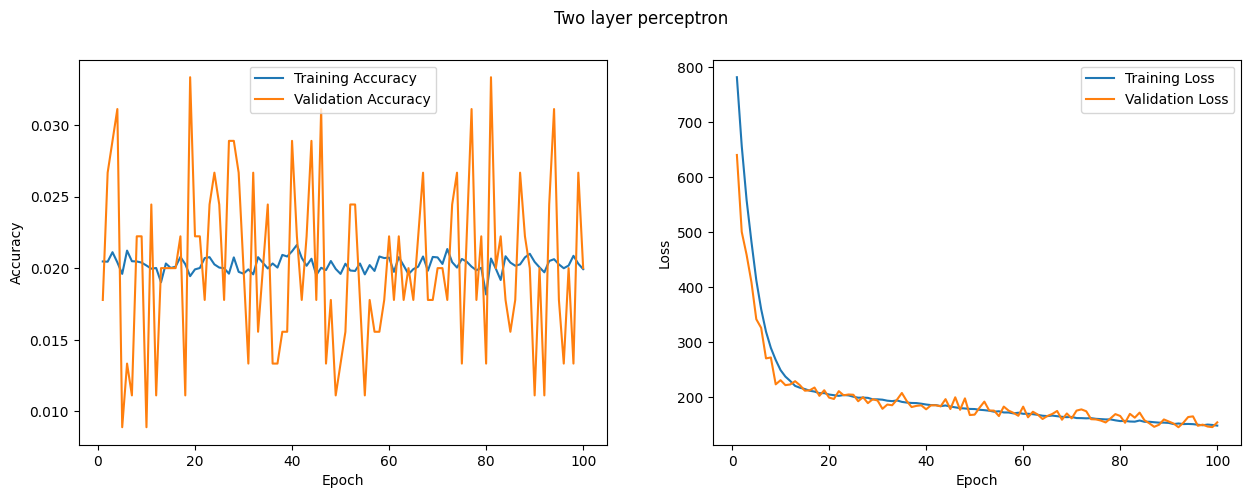

In [18]:
# Plot the accuracy and loss in the same figure
fig,ax = plt.subplots(1,2,figsize=(15, 5))
fig.suptitle('Two layer perceptron')
ax[0].plot(range(1,epochs+1),train_acc_list, label='Training Accuracy')
ax[0].plot(range(1,epochs+1),val_acc_list, label='Validation Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[1].plot(range(1,epochs+1),train_loss_list, label='Training Loss')
ax[1].plot(range(1,epochs+1),val_loss_list, label='Validation Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
plt.show()

### 評估模型

In [19]:
X.value = train_features
y.value = train_labels
forward_and_backward(graph)
Train_acc = top_1_acc(y.value, s1.value)

X.value = val_features
y.value = val_labels
forward_and_backward(graph)
Val_acc = top_1_acc(y.value, s1.value)

X.value = test_features
y.value = test_labels
forward_and_backward(graph)
Test_acc = top_1_acc(y.value, s1.value)

print('Two layer perceptron')
print('Train accuracy: {:.3f}; Val accuracy: {:.3f}; Test accuracy: {:.3f}'.format(
        Train_acc, Val_acc, Test_acc))

Two layer perceptron
Train accuracy: 0.024; Val accuracy: 0.016; Test accuracy: 0.016


---

---

## LeNet5

In [55]:
# Load in relevant libraries, and alias where appropriate
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.nn.functional import softmax

# Define relevant variables for the ML task
batch_size = 64
# num_classes = 10
learning_rate = 0.001
num_epochs = 10

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [63]:
# # mini-ImageNet datase
# 定義自己的dataset
class dataset_C0(torch.utils.data.Dataset):
    def __init__(self, file_path, image_size=(256,256)):
        with open(file_path, 'r') as f:
            lines = f.readlines()
        self.data = [line.rstrip().split() for line in lines]
        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            # transforms.Grayscale(num_output_channels=1),
            # transforms.CenterCrop(image_size-1),
            transforms.ToTensor(),
            # transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]) # RGB
            transforms.Normalize(mean=(0.456),std=(0.224)) # Gray
        ])
        self.root_path = './dataset/'

    def __getitem__(self, idx):
        image_path, image_label = self.data[idx]
        img = Image.open(self.root_path+image_path).convert('L') # GrayScale
        img = self.transform(img)
        return img, int(image_label)

    def __len__(self):
        return len(self.data)

# train set, val set, test set
num_classes = 50
IMG_SIZE = (128,128)#(32,32)
train_data = dataset_C0(os.path.join(dataset_path,'train.txt'), IMG_SIZE)
val_data = dataset_C0(os.path.join(dataset_path,'val.txt'), IMG_SIZE)
test_data = dataset_C0(os.path.join(dataset_path,'test.txt'), IMG_SIZE)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [64]:
data = next(iter(train_loader))
features, labels = data
images = features.to(device)
labels = labels.to(device)
print(features.shape)
print(labels.shape)

torch.Size([64, 1, 128, 128])
torch.Size([64])


In [4]:
'''
# # MNIST dataset
num_classes = 10
#Loading the dataset and preprocessing
train_dataset = torchvision.datasets.MNIST(root = './data',
                                           train = True,
                                           transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1307,), std = (0.3081,))]),
                                           download = True)


test_dataset = torchvision.datasets.MNIST(root = './data',
                                          train = False,
                                          transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1325,), std = (0.3105,))]),
                                          download=True)


train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)


test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)
'''

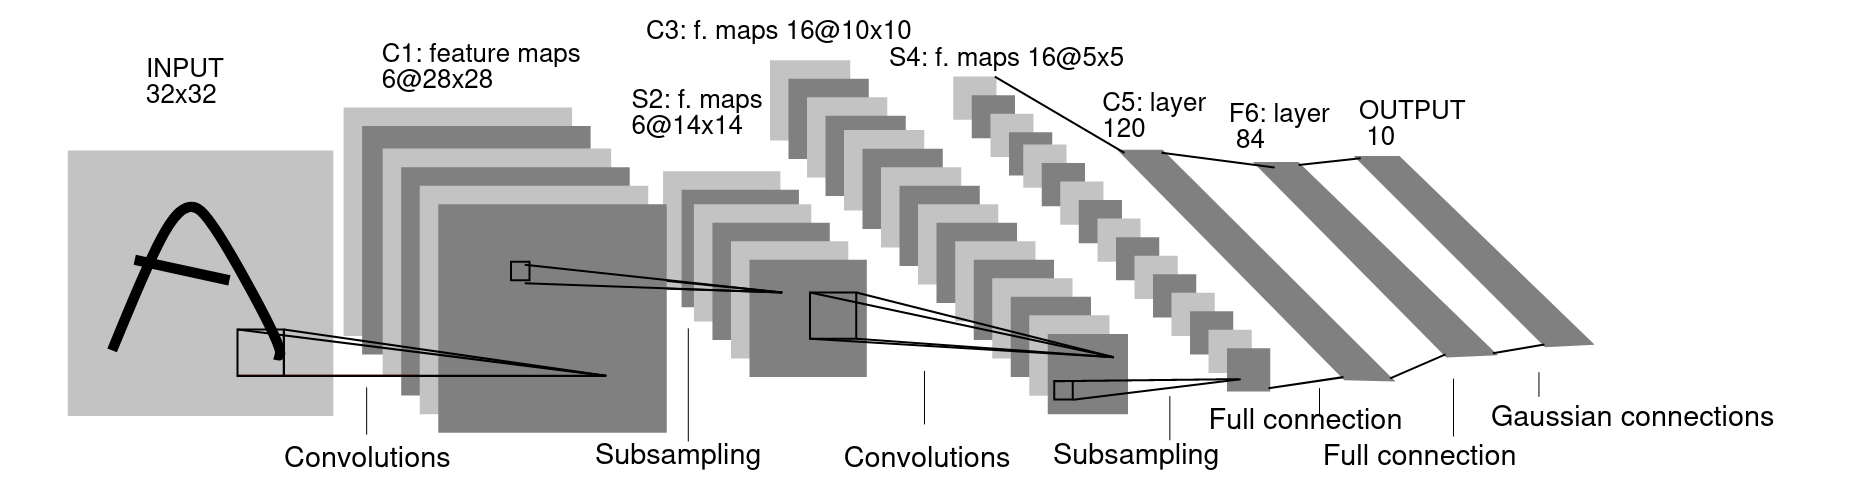

In [59]:
#(128,128)
#Defining the convolutional neural network
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(13456, 5000)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(5000, 500)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(500, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [6]:
#(32,32)
#Defining the convolutional neural network
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(400, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [60]:
model = LeNet5(num_classes).to(device)

#Setting the loss function
cost = nn.CrossEntropyLoss()

#Setting the optimizer with the model parameters and learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#this is defined to print how many steps are remaining when training
total_step = len(train_loader)

In [61]:
print(model)

LeNet5(
  (layer1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=13456, out_features=5000, bias=True)
  (relu): ReLU()
  (fc1): Linear(in_features=5000, out_features=500, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=500, out_features=50, bias=True)
)


### Training

In [65]:
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
total_step = len(train_loader)
for epoch in range(num_epochs):
    train_loss = 0
    val_loss = 0
    train_acc = 0
    val_acc = 0
    ### training
    for i, (images, labels) in enumerate(train_loader):  
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = cost(outputs, labels)
        train_loss += loss
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Metrics
        # train_pred = torch.argmax(softmax(outputs, dim=1), dim=1)
        train_pred = softmax(outputs, dim=1)
        train_top_1 = top_1_acc(labels.cpu().numpy(), train_pred.cpu().detach().numpy())
        train_acc += train_top_1
        
    train_loss_list.append(train_loss/len(train_loader))
    train_acc_list.append(train_top_1/len(train_loader))
        
    ### validation
    model.eval()
    val_loss, val_acc = 0, 0
    with torch.inference_mode():
        for j, (images, labels) in enumerate(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = cost(outputs, labels)
            val_loss += loss
            
            # Metrics
            # val_pred = torch.argmax(softmax(outputs, dim=1), dim=1)
            val_pred = softmax(outputs, dim=1)
            val_top_1 = top_1_acc(labels.cpu().numpy(), train_pred.cpu().detach().numpy())
            val_acc += val_top_1

        val_loss_list.append(val_loss/len(val_loader))
        val_acc_list.append(val_acc/len(val_loader))
        
    print ('Epoch [{}/{}], Step [{}/{}], Training Loss: {:.4f}' 
           .format(epoch+1, num_epochs, i+1, len(train_loader), train_loss_list[-1].item()))
    print ('Epoch [{}/{}], Step [{}/{}], Validation Loss: {:.4f}' 
           .format(epoch+1, num_epochs, j+1, len(val_loader), val_loss_list[-1].item()))
        # if (i+1) % 400 == 0:
        #     print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
        # 		           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

/tmp/ipykernel_32702/1499586888.py:17: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  accuracy = np.mean(y_true==pred_top1)


Epoch [1/10], Step [990/990], Training Loss: 3.6033
Epoch [1/10], Step [8/8], Validation Loss: 3.3071
Epoch [2/10], Step [990/990], Training Loss: 3.1755
Epoch [2/10], Step [8/8], Validation Loss: 3.0916
Epoch [3/10], Step [990/990], Training Loss: 2.9867
Epoch [3/10], Step [8/8], Validation Loss: 2.9163
Epoch [4/10], Step [990/990], Training Loss: 2.7979
Epoch [4/10], Step [8/8], Validation Loss: 2.7957
Epoch [5/10], Step [990/990], Training Loss: 2.5863
Epoch [5/10], Step [8/8], Validation Loss: 2.8881
Epoch [6/10], Step [990/990], Training Loss: 2.3313
Epoch [6/10], Step [8/8], Validation Loss: 2.8060
Epoch [7/10], Step [990/990], Training Loss: 2.0498
Epoch [7/10], Step [8/8], Validation Loss: 3.0028
Epoch [8/10], Step [990/990], Training Loss: 1.7451
Epoch [8/10], Step [8/8], Validation Loss: 3.4236
Epoch [9/10], Step [990/990], Training Loss: 1.4523
Epoch [9/10], Step [8/8], Validation Loss: 3.8130
Epoch [10/10], Step [990/990], Training Loss: 1.1851
Epoch [10/10], Step [8/8], Va

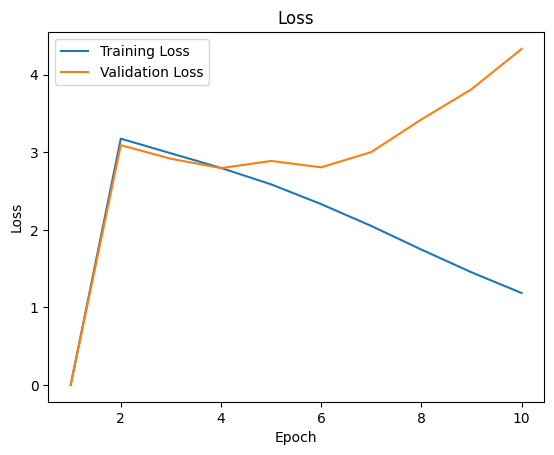

In [88]:
Train_Loss = np.zeros(num_epochs)
Val_Loss = np.zeros(num_epochs)
for i in range(1,num_epochs):
    Train_Loss[i] = train_loss_list[i].cpu().detach().numpy()
    Val_Loss[i] = val_loss_list[i].cpu().detach().numpy()
plt.plot(range(1,num_epochs+1),Train_Loss, label='Training Loss')
plt.plot(range(1,num_epochs+1),Val_Loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Testing

In [89]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
  
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the {} test images: {} %'.format(
        test_loader.dataset.__len__(), 100 * correct / total))
	 

Accuracy of the network on the 450 test images: 15.777777777777779 %


## Improved LeNet5

* Activation function: x = Sigmoid(x) ==> x = x*sigmoid(x)
* Kernel size: 5x5 ==> 3x3
* Increase one convolution layer to LeNet5 (any position).

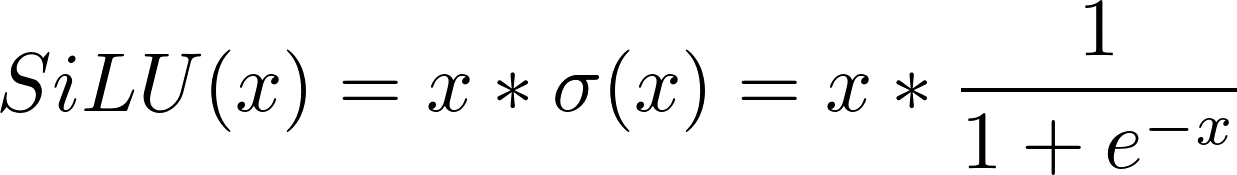

In [4]:
# Load in relevant libraries, and alias where appropriate
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# Define relevant variables for the ML task
batch_size = 64
num_classes = 10
learning_rate = 0.001
num_epochs = 10

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
#Loading the dataset and preprocessing
train_dataset = torchvision.datasets.MNIST(root = './data',
                                           train = True,
                                           transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1307,), std = (0.3081,))]),
                                           download = True)


test_dataset = torchvision.datasets.MNIST(root = './data',
                                          train = False,
                                          transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1325,), std = (0.3105,))]),
                                          download=True)


train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)


test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

In [14]:
#Defining the convolutional neural network
class Improved_LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(Improved_LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.SiLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.SiLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 20, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(20),
            nn.SiLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(80, 120)
        self.silu = nn.SiLU()
        self.fc1 = nn.Linear(120, 84)
        self.silu1 = nn.SiLU()
        self.fc2 = nn.Linear(84, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.silu(out)
        out = self.fc1(out)
        out = self.silu1(out)
        out = self.fc2(out)
        return out

In [15]:
model = Improved_LeNet5(num_classes).to(device)

#Setting the loss function
cost = nn.CrossEntropyLoss()

#Setting the optimizer with the model parameters and learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#this is defined to print how many steps are remaining when training
total_step = len(train_loader)

### Training

In [16]:
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(images)
        loss = cost(outputs, labels)
        	
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        		
        if (i+1) % 400 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
        		           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/10], Step [400/938], Loss: 0.1853
Epoch [1/10], Step [800/938], Loss: 0.0724
Epoch [2/10], Step [400/938], Loss: 0.0719
Epoch [2/10], Step [800/938], Loss: 0.0385
Epoch [3/10], Step [400/938], Loss: 0.0087
Epoch [3/10], Step [800/938], Loss: 0.0961
Epoch [4/10], Step [400/938], Loss: 0.0063
Epoch [4/10], Step [800/938], Loss: 0.0984
Epoch [5/10], Step [400/938], Loss: 0.1180
Epoch [5/10], Step [800/938], Loss: 0.0028
Epoch [6/10], Step [400/938], Loss: 0.0111
Epoch [6/10], Step [800/938], Loss: 0.0238
Epoch [7/10], Step [400/938], Loss: 0.0105
Epoch [7/10], Step [800/938], Loss: 0.0242
Epoch [8/10], Step [400/938], Loss: 0.0140
Epoch [8/10], Step [800/938], Loss: 0.0976
Epoch [9/10], Step [400/938], Loss: 0.0383
Epoch [9/10], Step [800/938], Loss: 0.0080
Epoch [10/10], Step [400/938], Loss: 0.0018
Epoch [10/10], Step [800/938], Loss: 0.0289


### Testing

In [17]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
  
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the network on the 10000 test images: 99.04 %
